In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf


# a

In [2]:
# Stock/Index
stock = "AAPL"  # Apple Inc.

# Expiration timeframe in years (2 months)
T = 2 / 12  # 2 months = 2/12 years

print(f"Selected Stock/Index: {stock}")
print(f"Expiration Timeframe (T): {T} years")

Selected Stock/Index: AAPL
Expiration Timeframe (T): 0.16666666666666666 years


# b

In [5]:
# Fetch current stock price for AAPL
stock = "AAPL"
stock_data = yf.Ticker(stock)
current_price = stock_data.history(period="1d")['Close'].iloc[-1]

# Pick the strike price closest to the current price
strike_price = round(current_price)

print(f"Selected Stock/Index: {stock}")
print(f"Current Stock Price: ${current_price:.2f}")
print(f"Closest Strike Price: ${strike_price}")

Selected Stock/Index: AAPL
Current Stock Price: $207.15
Closest Strike Price: $207


# C

In [7]:
# Risk-free rate (2-month US Treasury yield as an example)
risk_free_rate = 0.05 / 100  # 0.05% annualized

print(f"Risk-Free Rate: {risk_free_rate:.4f}")

Risk-Free Rate: 0.0005


# d

In [8]:
# Fetch historical stock price data for AAPL (1 year of daily data)
historical_data = stock_data.history(period="1y")

# Calculate daily returns
historical_data['Returns'] = historical_data['Close'].pct_change()

# Estimate annualized volatility
volatility = np.std(historical_data['Returns'].dropna()) * np.sqrt(252)  # 252 trading days in a year

print(f"Estimated Volatility: {volatility:.4f}")

Estimated Volatility: 0.2147


# e

In [9]:
dividend_yield = stock_data.info['dividendYield']

# Convert dividend yield to annual percentage
if dividend_yield is not None:
    dividend_yield = dividend_yield * 100  # Convert to percentage
else:
    dividend_yield = 0.0

print(f"Dividend Yield: {dividend_yield:.2f}%")

Dividend Yield: 0.52%


# 2a

In [10]:
# Black-Scholes formula for call option price
def black_scholes_call(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Black-Scholes formula for put option price
def black_scholes_put(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return put_price

# Calculate call and put option prices using previously defined variables
call_price = black_scholes_call(current_price, strike_price, T, risk_free_rate, volatility, dividend_yield)
put_price = black_scholes_put(current_price, strike_price, T, risk_free_rate, volatility, dividend_yield)

print(f"European Call Option Price: ${call_price:.2f}")
print(f"European Put Option Price: ${put_price:.2f}")

# Verify put-call parity: C - P = S * exp(-q * T) - K * exp(-r * T)
put_call_parity = call_price - put_price
expected_parity_value = current_price * np.exp(-dividend_yield * T) - strike_price * np.exp(-risk_free_rate * T)

print(f"Put-Call Parity Difference: {put_call_parity - expected_parity_value:.4f}")


European Call Option Price: $1.51
European Put Option Price: $18.54
Put-Call Parity Difference: 0.0000


# b

In [11]:
def black_scholes_greeks(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Delta
    delta_call = np.exp(-q * T) * norm.cdf(d1)
    delta_put = np.exp(-q * T) * (norm.cdf(d1) - 1)
    
    # Gamma
    gamma = (np.exp(-q * T) * norm.pdf(d1)) / (S * sigma * np.sqrt(T))
    
    # Theta
    theta_call = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
                  - r * K * np.exp(-r * T) * norm.cdf(d2)
                  + q * S * np.exp(-q * T) * norm.cdf(d1))
    theta_put = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)
                 - q * S * np.exp(-q * T) * norm.cdf(-d1))
    
    # Vega
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    
    # Rho
    rho_call = K * T * np.exp(-r * T) * norm.cdf(d2)
    rho_put = -K * T * np.exp(-r * T) * norm.cdf(-d2)
    
    return {
        "delta_call": delta_call,
        "delta_put": delta_put,
        "gamma": gamma,
        "theta_call": theta_call / 365,  # per day
        "theta_put": theta_put / 365,    # per day
        "vega": vega / 100,              # per 1% change in volatility
        "rho_call": rho_call / 100,      # per 1% change in interest rate
        "rho_put": rho_put / 100         # per 1% change in interest rate
    }

# Calculate Greeks using previously defined variables
greeks = black_scholes_greeks(current_price, strike_price, T, risk_free_rate, volatility, dividend_yield)

print("Greeks for the European Call Option:")
print(f"Delta: {greeks['delta_call']:.4f}")
print(f"Gamma: {greeks['gamma']:.4f}")
print(f"Theta: {greeks['theta_call']:.4f} per day")
print(f"Vega: {greeks['vega']:.4f} per 1% change in volatility")
print(f"Rho: {greeks['rho_call']:.4f} per 1% change in interest rate")

print("\nGreeks for the European Put Option:")
print(f"Delta: {greeks['delta_put']:.4f}")
print(f"Gamma: {greeks['gamma']:.4f}")
print(f"Theta: {greeks['theta_put']:.4f} per day")
print(f"Vega: {greeks['vega']:.4f} per 1% change in volatility")
print(f"Rho: {greeks['rho_put']:.4f} per 1% change in interest rate")


Greeks for the European Call Option:
Delta: 0.1603
Gamma: 0.0130
Theta: 0.0120 per day
Vega: 0.1997 per 1% change in volatility
Rho: 0.0528 per 1% change in interest rate

Greeks for the European Put Option:
Delta: -0.7567
Gamma: 0.0130
Theta: -0.2583 per day
Vega: 0.1997 per 1% change in volatility
Rho: -0.2922 per 1% change in interest rate


# C

C:\Users\Tiago\AppData\Local\Temp\ipykernel_10624\3870994438.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


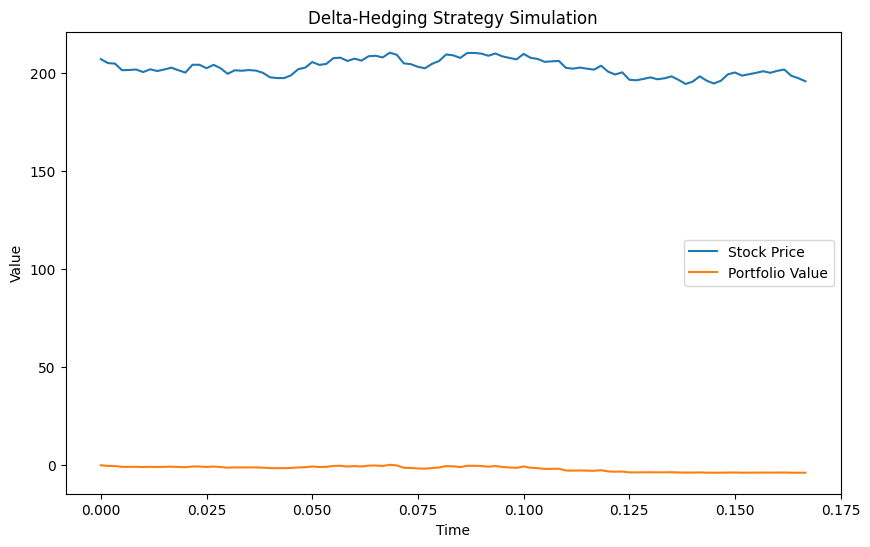

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
S0 = current_price
K = strike_price
r = risk_free_rate
sigma = volatility
T = 2 / 12  # 2 months
q = dividend_yield

# Simulation parameters
num_simulations = 1  # Single path simulation for delta-hedging
num_intervals = 100  # Number of time intervals

# Time step
dt = T / num_intervals

# Function to simulate stock price paths
def simulate_stock_path(S0, r, sigma, T, num_intervals, num_simulations):
    dt = T / num_intervals
    prices = np.zeros((num_intervals + 1, num_simulations))
    prices[0] = S0
    for t in range(1, num_intervals + 1):
        Z = np.random.standard_normal(num_simulations)
        prices[t] = prices[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return prices

# Function to calculate Delta
def delta_call(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = np.exp(-q * T) * norm.cdf(d1)
    return delta

# Simulate the stock price path
stock_path = simulate_stock_path(S0, r, sigma, T, num_intervals, num_simulations).flatten()

# Initialize variables for delta-hedging
portfolio_values = np.zeros(num_intervals + 1)
stock_positions = np.zeros(num_intervals + 1)
cash_positions = np.zeros(num_intervals + 1)

# Initial delta
delta = delta_call(S0, K, T, r, sigma, q)
stock_positions[0] = delta
cash_positions[0] = -delta * S0

# Simulate delta-hedging
for t in range(1, num_intervals + 1):
    time_remaining = T - t * dt
    delta_new = delta_call(stock_path[t], K, time_remaining, r, sigma, q)
    stock_positions[t] = delta_new
    cash_positions[t] = cash_positions[t-1] * np.exp(r * dt) - (delta_new - stock_positions[t-1]) * stock_path[t]
    portfolio_values[t] = stock_positions[t] * stock_path[t] + cash_positions[t]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, num_intervals + 1), stock_path, label='Stock Price')
plt.plot(np.linspace(0, T, num_intervals + 1), portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Delta-Hedging Strategy Simulation')
plt.legend()
plt.show()


# 3A

In [15]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define the parameters
S0 = current_price
K = strike_price
r = risk_free_rate
sigma = volatility
T = 2 / 12  # 2 months
q = dividend_yield

# Simulation parameters
num_simulations = 50000
num_intervals = 100  # Number of time intervals

# Function to simulate stock price paths
def simulate_stock_paths(S0, r, sigma, T, num_intervals, num_simulations):
    dt = T / num_intervals
    stock_paths = np.zeros((num_simulations, num_intervals + 1))
    stock_paths[:, 0] = S0
    for t in range(1, num_intervals + 1):
        Z = np.random.standard_normal(num_simulations)
        stock_paths[:, t] = stock_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return stock_paths

# Simulate stock price paths
stock_paths = simulate_stock_paths(S0, r, sigma, T, num_intervals, num_simulations)

# Calculate the payoff for call and put options
call_payoffs = np.maximum(stock_paths[:, -1] - K, 0)
put_payoffs = np.maximum(K - stock_paths[:, -1], 0)

# Discount the payoffs to present value
call_option_price_mc = np.exp(-r * T) * np.mean(call_payoffs)
put_option_price_mc = np.exp(-r * T) * np.mean(put_payoffs)

print(f"Monte Carlo Estimated Call Option Price: ${call_option_price_mc:.2f}")
print(f"Monte Carlo Estimated Put Option Price: ${put_option_price_mc:.2f}")

# Black-Scholes formula for call option price
def black_scholes_call(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Black-Scholes formula for put option price
def black_scholes_put(S, K, T, r, sigma, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return put_price

# Calculate call and put option prices using Black-Scholes formula
call_price = black_scholes_call(S0, K, T, r, sigma, q)
put_price = black_scholes_put(S0, K, T, r, sigma, q)

print(f"Black-Scholes Call Option Price: ${call_price:.2f}")
print(f"Black-Scholes Put Option Price: ${put_price:.2f}")

# Fetch actual market option prices for AAPL
options_chain = stock_data.option_chain(stock_data.options[0])
calls = options_chain.calls
puts = options_chain.puts

# Find the closest matching strike price in the options chain
closest_call = calls.iloc[(calls['strike'] - K).abs().argsort()[:1]]
closest_put = puts.iloc[(puts['strike'] - K).abs().argsort()[:1]]

market_call_price = closest_call['lastPrice'].values[0]
market_put_price = closest_put['lastPrice'].values[0]

print(f"Market Call Option Price: ${market_call_price:.2f}")
print(f"Market Put Option Price: ${market_put_price:.2f}")

# Compare results
print(f"Comparison for Call Option:")
print(f"Black-Scholes Price: ${call_price:.2f}")
print(f"Monte Carlo Price: ${call_option_price_mc:.2f}")
print(f"Market Price: ${market_call_price:.2f}")

print(f"\nComparison for Put Option:")
print(f"Black-Scholes Price: ${put_price:.2f}")
print(f"Monte Carlo Price: ${put_option_price_mc:.2f}")
print(f"Market Price: ${market_put_price:.2f}")


Monte Carlo Estimated Call Option Price: $7.26
Monte Carlo Estimated Put Option Price: $7.16
Black-Scholes Call Option Price: $1.51
Black-Scholes Put Option Price: $18.54
Market Call Option Price: $2.52
Market Put Option Price: $2.83
Comparison for Call Option:
Black-Scholes Price: $1.51
Monte Carlo Price: $7.26
Market Price: $2.52

Comparison for Put Option:
Black-Scholes Price: $18.54
Monte Carlo Price: $7.16
Market Price: $2.83


$ B

In [16]:
import numpy as np
from scipy.stats import norm
import yfinance as yf

# Fetch current stock price for AAPL
stock = "AAPL"
stock_data = yf.Ticker(stock)
current_price = stock_data.history(period="1d")['Close'].iloc[-1]

# Pick the strike price closest to the current price
strike_price = round(current_price)

# Risk-free rate (2-month US Treasury yield as an example)
risk_free_rate = 0.05 / 100  # 0.05% annualized

# Fetch historical stock price data for AAPL (1 year of daily data)
historical_data = stock_data.history(period="1y")

# Calculate daily returns
historical_data['Returns'] = historical_data['Close'].pct_change()

# Estimate annualized volatility
volatility = np.std(historical_data['Returns'].dropna()) * np.sqrt(252)  # 252 trading days in a year

# Fetch dividend yield
dividend_yield = stock_data.info['dividendYield']
if dividend_yield is not None:
    dividend_yield = dividend_yield
else:
    dividend_yield = 0.0

# Expiration timeframe in years (2 months)
T = 2 / 12  # 2 months = 2/12 years

# Simulation parameters
num_simulations = 50000
num_intervals = 100  # Number of intervals in each simulation

# Function to simulate stock price paths
def simulate_stock_paths(S0, r, sigma, T, num_intervals, num_simulations):
    dt = T / num_intervals
    stock_paths = np.zeros((num_simulations, num_intervals + 1))
    stock_paths[:, 0] = S0
    for t in range(1, num_intervals + 1):
        Z = np.random.standard_normal(num_simulations)
        stock_paths[:, t] = stock_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return stock_paths

# Simulate stock price paths
stock_paths = simulate_stock_paths(current_price, risk_free_rate, volatility, T, num_intervals, num_simulations)

# Function to calculate option price
def calculate_option_price(stock_paths, K, r, T, option_type='call'):
    if option_type == 'call':
        payoffs = np.maximum(stock_paths[:, -1] - K, 0)
    else:
        payoffs = np.maximum(K - stock_paths[:, -1], 0)
    return np.exp(-r * T) * np.mean(payoffs)

# Function to estimate Greeks using finite differences
def estimate_greeks(S0, K, T, r, sigma, q, num_simulations, num_intervals, epsilon=0.01, h=0.01):
    # Base price for call and put
    stock_paths = simulate_stock_paths(S0, r, sigma, T, num_intervals, num_simulations)
    call_price = calculate_option_price(stock_paths, K, r, T, 'call')
    put_price = calculate_option_price(stock_paths, K, r, T, 'put')
    
    # Delta
    stock_paths_up = simulate_stock_paths(S0 + h, r, sigma, T, num_intervals, num_simulations)
    stock_paths_down = simulate_stock_paths(S0 - h, r, sigma, T, num_intervals, num_simulations)
    call_price_up = calculate_option_price(stock_paths_up, K, r, T, 'call')
    call_price_down = calculate_option_price(stock_paths_down, K, r, T, 'call')
    put_price_up = calculate_option_price(stock_paths_up, K, r, T, 'put')
    put_price_down = calculate_option_price(stock_paths_down, K, r, T, 'put')
    delta_call = (call_price_up - call_price_down) / (2 * h)
    delta_put = (put_price_up - put_price_down) / (2 * h)
    
    # Gamma
    gamma_call = (call_price_up - 2 * call_price + call_price_down) / (h ** 2)
    gamma_put = (put_price_up - 2 * put_price + put_price_down) / (h ** 2)
    
    # Theta
    stock_paths_theta = simulate_stock_paths(S0, r, sigma, T - epsilon, num_intervals, num_simulations)
    call_price_theta = calculate_option_price(stock_paths_theta, K, r, T - epsilon, 'call')
    put_price_theta = calculate_option_price(stock_paths_theta, K, r, T - epsilon, 'put')
    theta_call = (call_price_theta - call_price) / epsilon
    theta_put = (put_price_theta - put_price) / epsilon
    
    # Vega
    stock_paths_vega = simulate_stock_paths(S0, r, sigma + epsilon, T, num_intervals, num_simulations)
    call_price_vega = calculate_option_price(stock_paths_vega, K, r, T, 'call')
    put_price_vega = calculate_option_price(stock_paths_vega, K, r, T, 'put')
    vega_call = (call_price_vega - call_price) / epsilon
    vega_put = (put_price_vega - put_price) / epsilon
    
    # Rho
    stock_paths_rho = simulate_stock_paths(S0, r + epsilon, sigma, T, num_intervals, num_simulations)
    call_price_rho = calculate_option_price(stock_paths_rho, K, r + epsilon, T, 'call')
    put_price_rho = calculate_option_price(stock_paths_rho, K, r + epsilon, T, 'put')
    rho_call = (call_price_rho - call_price) / epsilon
    rho_put = (put_price_rho - put_price) / epsilon
    
    return {
        'delta_call': delta_call,
        'delta_put': delta_put,
        'gamma_call': gamma_call,
        'gamma_put': gamma_put,
        'theta_call': theta_call,
        'theta_put': theta_put,
        'vega_call': vega_call,
        'vega_put': vega_put,
        'rho_call': rho_call,
        'rho_put': rho_put
    }

# Estimate Greeks using previously defined variables
greeks_mc = estimate_greeks(current_price, strike_price, T, risk_free_rate, volatility, dividend_yield, num_simulations, num_intervals)

print("Greeks estimated using Monte Carlo simulation:")
print("\nCall Option Greeks:")
print(f"Delta: {greeks_mc['delta_call']:.4f}")
print(f"Gamma: {greeks_mc['gamma_call']:.4f}")
print(f"Theta: {greeks_mc['theta_call']:.4f}")
print(f"Vega: {greeks_mc['vega_call']:.4f}")
print(f"Rho: {greeks_mc['rho_call']:.4f}")

print("\nPut Option Greeks:")
print(f"Delta: {greeks_mc['delta_put']:.4f}")
print(f"Gamma: {greeks_mc['gamma_put']:.4f}")
print(f"Theta: {greeks_mc['theta_put']:.4f}")
print(f"Vega: {greeks_mc['vega_put']:.4f}")
print(f"Rho: {greeks_mc['rho_put']:.4f}")


Greeks estimated using Monte Carlo simulation:

Call Option Greeks:
Delta: 2.8924
Gamma: -2236.5518
Theta: -29.7355
Vega: 23.4467
Rho: 2.4093

Put Option Greeks:
Delta: 0.8706
Gamma: 2489.1317
Theta: -19.1842
Vega: 37.6398
Rho: -12.4020
